General input setting

In [3]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

np.random.seed(42)

DATA_PATH = "flights.csv"
df = pd.read_csv(DATA_PATH)

target_col = "ARRIVAL_DELAY"
X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
  X, y, test_size=0.25, random_state=42, shuffle=True
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7500, 659), (2500, 659), (7500,), (2500,))

General helper methods

In [4]:
def binary_report(y_true, y_pred):
  # Compute and return common binary classification metrics
  cm = confusion_matrix(y_true, y_pred)
  tn, fp, fn, tp = cm.ravel()
  acc = accuracy_score(y_true, y_pred)
  err = 1 - acc
  prec = precision_score(y_true, y_pred, zero_division=0)
  rec = recall_score(y_true, y_pred, zero_division=0)
  f1 = f1_score(y_true, y_pred, zero_division=0)
  return {
    "confusion_matrix": cm,
    "TP": int(tp), "FP": int(fp), "TN": int(tn), "FN": int(fn),
    "accuracy": float(acc), "error": float(err),
    "precision": float(prec), "recall": float(rec), "f1": float(f1)
  }

def print_binary_report(report_dict, title=None):
  # Pretty-print a binary classification report
  if title is not None:
    print(title)
  print("Confusion matrix:\n", report_dict["confusion_matrix"])
  print("TP:", report_dict["TP"], "FP:", report_dict["FP"], "TN:", report_dict["TN"], "FN:", report_dict["FN"])
  print("Accuracy:", report_dict["accuracy"], "Error:", report_dict["error"])
  print("Precision:", report_dict["precision"], "Recall:", report_dict["recall"], "F1:", report_dict["f1"])

Problem 1(c)

In [5]:
def fit_linear_and_ridge_simulation(N=1000, lambdas=(1, 10, 100, 1000, 10000), seed=42):
  # Simulate data and fit linear regression and ridge regression in closed form
  rng = np.random.default_rng(seed)
  X = rng.uniform(-2, 2, size=N)
  e = rng.normal(0, np.sqrt(2), size=N)
  Y = 1 + 2 * X + e

  X_design = np.column_stack([np.ones(N), X])

  theta_lin = np.linalg.inv(X_design.T @ X_design) @ (X_design.T @ Y)
  pred_lin = X_design @ theta_lin
  mse_lin = float(np.mean((pred_lin - Y) ** 2))
  r2_lin = float(1 - np.sum((pred_lin - Y) ** 2) / np.sum((Y - np.mean(Y)) ** 2))

  results = []
  results.append({
    "model": "linear",
    "lambda": 0,
    "intercept": float(theta_lin[0]),
    "slope": float(theta_lin[1]),
    "mse": mse_lin,
    "r2": r2_lin
  })

  for lam in lambdas:
    I = np.eye(X_design.shape[1])
    theta_ridge = np.linalg.inv(X_design.T @ X_design + lam * I) @ (X_design.T @ Y)
    pred_ridge = X_design @ theta_ridge
    mse = float(np.mean((pred_ridge - Y) ** 2))
    r2 = float(1 - np.sum((pred_ridge - Y) ** 2) / np.sum((Y - np.mean(Y)) ** 2))
    results.append({
      "model": "ridge",
      "lambda": lam,
      "intercept": float(theta_ridge[0]),
      "slope": float(theta_ridge[1]),
      "mse": mse,
      "r2": r2
    })

  return pd.DataFrame(results)

p1c_df = fit_linear_and_ridge_simulation()
p1c_df

,model,lambda,intercept,slope,mse,r2
0,linear,0,0.890666,2.071593,2.049294,0.739984
1,ridge,1,0.889759,2.070063,2.049298,0.739984
2,ridge,10,0.881677,2.056388,2.049686,0.739934
3,ridge,100,0.808232,1.928980,2.083466,0.735648
4,ridge,1000,0.440364,1.191318,3.296278,0.581766
5,ridge,10000,0.079097,0.247060,7.198918,0.086596


Problem 2 

2(a)

In [8]:
logreg_pkg = LogisticRegression(max_iter=2000, random_state=42)
logreg_pkg.fit(X_train, y_train)

y_test_pred = logreg_pkg.predict(X_test)
rep_2a = binary_report(y_test, y_test_pred)
print_binary_report(rep_2a, title="Problem 2(a) Logistic Regression (test set)")

Problem 2(a) Logistic Regression (test set)
Confusion matrix:
 [[707 544]
 [505 744]]
TP: 744 FP: 544 TN: 707 FN: 505
Accuracy: 0.5804 Error: 0.4196
Precision: 0.577639751552795 Recall: 0.5956765412329864 F1: 0.5865195112337407


2(b)

In [9]:
coef = logreg_pkg.coef_.ravel()
feat_names = X.columns.to_list()

coef_df = pd.DataFrame({"feature": feat_names, "coef": coef})
coef_df_sorted = coef_df.sort_values("coef", ascending=False).reset_index(drop=True)

top_pos3 = coef_df_sorted.head(3)
top_neg3 = coef_df_sorted.tail(3).sort_values("coef", ascending=True)

most_contrib = coef_df.iloc[np.argmax(np.abs(coef))]

print("Most contributing feature by |coef|:")
print(most_contrib.to_string(index=False))
print("\nTop 3 most positively correlated features:")
print(top_pos3.to_string(index=False))
print("\nTop 3 most negatively correlated features:")
print(top_neg3.to_string(index=False))

Most contributing feature by |coef|:
SCHEDULED_DEPARTURE
           0.437035

Top 3 most positively correlated features:
                feature     coef
    SCHEDULED_DEPARTURE 0.437035
DESTINATION_AIRPORT_WRG 0.197158
     ORIGIN_AIRPORT_CWA 0.152991

Top 3 most negatively correlated features:
                feature      coef
DESTINATION_AIRPORT_ABI -0.225254
     ORIGIN_AIRPORT_FSM -0.171173
DESTINATION_AIRPORT_LRD -0.158592


2(c)

In [10]:
def threshold_metrics(y_true, prob_pos, thresholds):
  # Compute accuracy/precision/recall across thresholds
  rows = []
  for T in thresholds:
    y_pred = (prob_pos >= T).astype(int)
    rows.append({
      "T": float(T),
      "accuracy": float(accuracy_score(y_true, y_pred)),
      "precision": float(precision_score(y_true, y_pred, zero_division=0)),
      "recall": float(recall_score(y_true, y_pred, zero_division=0))
    })
  return pd.DataFrame(rows)

test_prob_pos = logreg_pkg.predict_proba(X_test)[:, 1]
p2c_df = threshold_metrics(y_test.to_numpy(), test_prob_pos, thresholds=[0.25, 0.5, 0.75, 0.9])
p2c_df

,T,accuracy,precision,recall
0,0.25,0.5280,0.514890,0.955164
1,0.50,0.5804,0.577640,0.595677
2,0.75,0.5152,0.596859,0.091273
3,0.90,0.5052,0.650000,0.020817


Problem 3

In [11]:
def sigmoid(z):
  # Compute sigmoid values
  return 1 / (1 + np.exp(-z))

def logistic_loss(y, p):
  # Compute average cross-entropy loss
  eps = 1e-12
  p = np.clip(p, eps, 1 - eps)
  return float(-np.mean(y * np.log(p) + (1 - y) * np.log(1 - p)))

def train_logreg_gd(X, y, lr=0.1, iters=100, seed=42):
  # Train logistic regression with batch gradient descent
  rng = np.random.default_rng(seed)
  n, d = X.shape
  w = rng.normal(0, 0.01, size=d)
  b = 0.0

  loss_hist = []
  checkpoints = {10, 50, 100}

  for t in range(1, iters + 1):
    z = X @ w + b
    p = sigmoid(z)
    grad_w = (X.T @ (p - y)) / n
    grad_b = float(np.mean(p - y))

    w = w - lr * grad_w
    b = b - lr * grad_b

    if t in checkpoints:
      loss_hist.append((t, logistic_loss(y, sigmoid(X @ w + b))))

  return w, b, loss_hist

def predict_logreg_gd(X, w, b, threshold=0.5):
  # Predict labels for logistic regression parameters
  p = sigmoid(X @ w + b)
  return (p >= threshold).astype(int), p

In [12]:
lrs = [0.1, 0.01, 0.001]
p3_loss_rows = []
p3_metrics_rows = []

for lr in lrs:
  w, b, loss_hist = train_logreg_gd(X_train, y_train.to_numpy(), lr=lr, iters=100, seed=42)
  for (t, L) in loss_hist:
    p3_loss_rows.append({"lr": lr, "iter": t, "train_loss": L})

  y_train_pred_gd, _ = predict_logreg_gd(X_train, w, b, threshold=0.5)
  y_test_pred_gd, _ = predict_logreg_gd(X_test, w, b, threshold=0.5)

  rep_train = binary_report(y_train, y_train_pred_gd)
  rep_test = binary_report(y_test, y_test_pred_gd)

  p3_metrics_rows.append({
    "lr": lr,
    "split": "train",
    "accuracy": rep_train["accuracy"],
    "precision": rep_train["precision"],
    "recall": rep_train["recall"],
    "f1": rep_train["f1"]
  })
  p3_metrics_rows.append({
    "lr": lr,
    "split": "test",
    "accuracy": rep_test["accuracy"],
    "precision": rep_test["precision"],
    "recall": rep_test["recall"],
    "f1": rep_test["f1"]
  })

p3_loss_df = pd.DataFrame(p3_loss_rows).sort_values(["lr", "iter"]).reset_index(drop=True)
p3_metrics_df = pd.DataFrame(p3_metrics_rows).sort_values(["lr", "split"]).reset_index(drop=True)

p3_loss_df, p3_metrics_df

(      lr  iter  train_loss
 0  0.001    10    0.697669
 1  0.001    50    0.696064
 2  0.001   100    0.694114
 3  0.010    10    0.694109
 4  0.010    50    0.680508
 5  0.010   100    0.667580
 6  0.100    10    0.667283
 7  0.100    50    0.630013
 8  0.100   100    0.621970,
       lr  split  accuracy  precision    recall        f1
 0  0.001   test  0.522800   0.522876  0.512410  0.517590
 1  0.001  train  0.523333   0.519850  0.520548  0.520199
 2  0.010   test  0.561600   0.559441  0.576461  0.567823
 3  0.010  train  0.609733   0.606247  0.609992  0.608114
 4  0.100   test  0.581600   0.579111  0.594876  0.586888
 5  0.100  train  0.644933   0.642244  0.642761  0.642502)

In [13]:
y_train_pred_pkg = logreg_pkg.predict(X_train)
y_test_pred_pkg = logreg_pkg.predict(X_test)

rep_pkg_train = binary_report(y_train, y_train_pred_pkg)
rep_pkg_test = binary_report(y_test, y_test_pred_pkg)

print_binary_report(rep_pkg_train, title="Package Logistic Regression (train)")
print()
print_binary_report(rep_pkg_test, title="Package Logistic Regression (test)")

Package Logistic Regression (train)
Confusion matrix:
 [[2440 1337]
 [1303 2420]]
TP: 2420 FP: 1337 TN: 2440 FN: 1303
Accuracy: 0.648 Error: 0.352
Precision: 0.6441309555496406 Recall: 0.650013430029546 F1: 0.6470588235294118

Package Logistic Regression (test)
Confusion matrix:
 [[707 544]
 [505 744]]
TP: 744 FP: 544 TN: 707 FN: 505
Accuracy: 0.5804 Error: 0.4196
Precision: 0.577639751552795 Recall: 0.5956765412329864 F1: 0.5865195112337407


Problem 4

4(a)

In [14]:
def kfold_indices(n, k, seed=42):
  # Generate k-fold index splits
  rng = np.random.default_rng(seed)
  idx = np.arange(n)
  rng.shuffle(idx)
  folds = np.array_split(idx, k)
  return folds

def eval_knn_cv(X, y, k_values=(3, 5, 7, 21), folds=5, seed=42):
  # Cross-validate kNN over candidate k values
  n = X.shape[0]
  fold_list = kfold_indices(n, folds, seed=seed)

  rows = []
  for k in k_values:
    per_fold = []
    for i in range(folds):
      val_idx = fold_list[i]
      train_idx = np.concatenate([fold_list[j] for j in range(folds) if j != i])

      Xtr, Xva = X[train_idx], X[val_idx]
      ytr, yva = y.iloc[train_idx], y.iloc[val_idx]

      model = KNeighborsClassifier(n_neighbors=int(k))
      model.fit(Xtr, ytr)
      yva_pred = model.predict(Xva)
      rep = binary_report(yva, yva_pred)
      per_fold.append(rep)

    avg_acc = float(np.mean([r["accuracy"] for r in per_fold]))
    avg_err = float(np.mean([r["error"] for r in per_fold]))
    avg_prec = float(np.mean([r["precision"] for r in per_fold]))
    avg_rec = float(np.mean([r["recall"] for r in per_fold]))
    avg_f1 = float(np.mean([r["f1"] for r in per_fold]))

    rows.append({
      "k": int(k),
      "cv_accuracy": avg_acc,
      "cv_error": avg_err,
      "cv_precision": avg_prec,
      "cv_recall": avg_rec,
      "cv_f1": avg_f1
    })

  out = pd.DataFrame(rows).sort_values("cv_error").reset_index(drop=True)
  return out

p4a_df = eval_knn_cv(X_train, y_train, k_values=(3, 5, 7, 21), folds=5, seed=42)
p4a_df

,k,cv_accuracy,cv_error,cv_precision,cv_recall,cv_f1
0,21,0.537600,0.462400,0.532701,0.558000,0.544511
1,7,0.529867,0.470133,0.526098,0.538285,0.531626
2,5,0.524800,0.475200,0.520845,0.541563,0.530403
3,3,0.517200,0.482800,0.513292,0.530158,0.521151


In [15]:
best_k = int(p4a_df.iloc[0]["k"])
best_k

21

4(b)

In [16]:
knn = KNeighborsClassifier(n_neighbors=best_k)
lda = LinearDiscriminantAnalysis()
logreg = LogisticRegression(max_iter=2000, random_state=42)

knn.fit(X_train, y_train)
lda.fit(X_train, y_train)
logreg.fit(X_train, y_train)

models = [("kNN", knn), ("LogReg", logreg), ("LDA", lda)]

rows = []
for name, model in models:
  for split_name, Xs, ys in [("train", X_train, y_train), ("test", X_test, y_test)]:
    ypred = model.predict(Xs)
    rep = binary_report(ys, ypred)
    rows.append({
      "model": name,
      "split": split_name,
      "accuracy": rep["accuracy"],
      "error": rep["error"],
      "precision": rep["precision"],
      "recall": rep["recall"],
      "f1": rep["f1"]
    })

p4b_df = pd.DataFrame(rows).sort_values(["model", "split"]).reset_index(drop=True)
p4b_df

,model,split,accuracy,error,precision,recall,f1
0,LDA,test,0.579200,0.420800,0.575828,0.598879,0.587127
1,LDA,train,0.649467,0.350533,0.645401,0.652162,0.648764
2,LogReg,test,0.580400,0.419600,0.577640,0.595677,0.586520
3,LogReg,train,0.648000,0.352000,0.644131,0.650013,0.647059
4,kNN,test,0.518800,0.481200,0.517638,0.540432,0.528790
5,kNN,train,0.610000,0.390000,0.602835,0.628257,0.615283


4(c)

In [17]:
logreg_prob = logreg.predict_proba(X_test)[:, 1]
lda_prob = lda.predict_proba(X_test)[:, 1]

fpr_lr, tpr_lr, _ = roc_curve(y_test, logreg_prob)
fpr_lda, tpr_lda, _ = roc_curve(y_test, lda_prob)

auc_lr = float(auc(fpr_lr, tpr_lr))
auc_lda = float(auc(fpr_lda, tpr_lda))

auc_lr, auc_lda

(0.6058973477743026, 0.607202948609887)

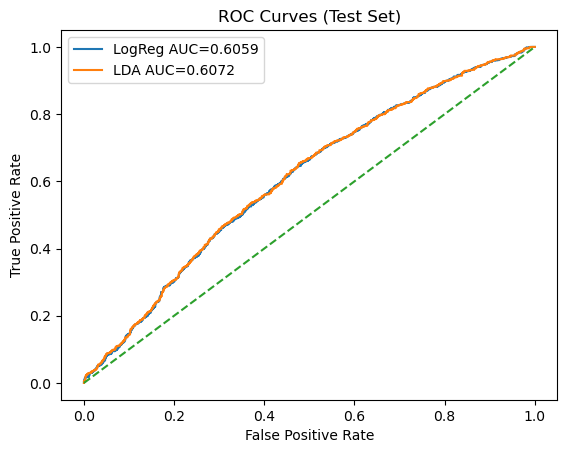

In [18]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr_lr, tpr_lr, label=f"LogReg AUC={auc_lr:.4f}")
plt.plot(fpr_lda, tpr_lda, label=f"LDA AUC={auc_lda:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Test Set)")
plt.legend()
plt.show()

4(d)

In [19]:
def roc_points_from_thresholds(y_true, prob_pos, thresholds):
  # Compute (FPR, TPR) pairs for given thresholds
  y_true = np.asarray(y_true).astype(int)
  prob_pos = np.asarray(prob_pos)

  pts = []
  for T in thresholds:
    y_pred = (prob_pos >= T).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    pts.append((float(T), float(fpr), float(tpr)))
  return pd.DataFrame(pts, columns=["T", "FPR", "TPR"])

thresholds = [i / 10 for i in range(0, 11)]
p4d_df = roc_points_from_thresholds(y_test.to_numpy(), logreg_prob, thresholds)
p4d_df

,T,FPR,TPR
0,0.0,1.000000,1.000000
1,0.1,0.972822,0.987190
2,0.2,0.944045,0.970376
3,0.3,0.836930,0.917534
4,0.4,0.642686,0.786229
5,0.5,0.434852,0.595677
6,0.6,0.247002,0.373899
7,0.7,0.107914,0.162530
8,0.8,0.028777,0.048839
9,0.9,0.011191,0.020817


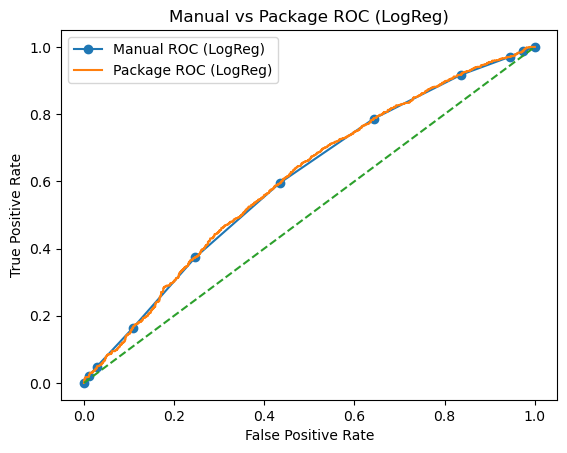

In [20]:
plt.figure()
plt.plot(p4d_df["FPR"], p4d_df["TPR"], marker="o", label="Manual ROC (LogReg)")
plt.plot(fpr_lr, tpr_lr, label="Package ROC (LogReg)")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Manual vs Package ROC (LogReg)")
plt.legend()
plt.show()

Problem 5

In [22]:
def cv_avg_error_for_model(X_raw_df, y_series, K, model_name, seed=42):
  # Run k-fold CV with per-fold scaling and return average validation error
  X_raw = X_raw_df.to_numpy()
  y = y_series.to_numpy().astype(int)

  n = X_raw.shape[0]
  folds = kfold_indices(n, K, seed=seed)

  errors = []
  for i in range(K):
    val_idx = folds[i]
    train_idx = np.concatenate([folds[j] for j in range(K) if j != i])

    Xtr_raw, Xva_raw = X_raw[train_idx], X_raw[val_idx]
    ytr, yva = y[train_idx], y[val_idx]

    sc = StandardScaler()
    Xtr = sc.fit_transform(Xtr_raw)
    Xva = sc.transform(Xva_raw)

    if model_name == "logreg":
      model = LogisticRegression(max_iter=2000, random_state=42)
    elif model_name == "lda":
      model = LinearDiscriminantAnalysis()
    else:
      raise ValueError("Unknown model_name")

    model.fit(Xtr, ytr)
    yva_pred = model.predict(Xva)
    err = 1 - accuracy_score(yva, yva_pred)
    errors.append(float(err))

  return float(np.mean(errors))

rows = []
for K in [5, 10]:
  avg_err_lr = cv_avg_error_for_model(X_train_raw, y_train, K, "logreg", seed=42)
  avg_err_lda = cv_avg_error_for_model(X_train_raw, y_train, K, "lda", seed=42)
  rows.append({"K": K, "model": "LogReg", "avg_val_error": avg_err_lr})
  rows.append({"K": K, "model": "LDA", "avg_val_error": avg_err_lda})

p5_df = pd.DataFrame(rows).sort_values(["K", "model"]).reset_index(drop=True)
p5_df

,K,model,avg_val_error
0,5,LDA,0.412933
1,5,LogReg,0.412800
2,10,LDA,0.415733
3,10,LogReg,0.414800
